## Analysis of how length of CoT output influences performance

___


In [18]:
import regex
import json
import numpy as np
import os
import pandas as pd
import re

In [108]:
def count_word_multilingual(text: str) -> int:
    """
    Performs rough tokenization of the input text and counts the number of tokens.
    Supports mixed languages including English, Chinese (including Japanese Kanji), 
    Spanish, Portuguese, French, German, Russian, Norwegian, and Japanese.
    
    Rules:
    1) [0-9\\.]+ : Matches consecutive digits (including decimal points) as a single token.
    2) \\p{Han} : Matches a single Chinese character (including Kanji used in Japanese).
    3) \\p{Hiragana}+ : Matches consecutive Hiragana characters as a single token.
    4) \\p{Katakana}+ : Matches consecutive Katakana characters as a single token.
    5) \\p{Cyrillic}+ : Matches consecutive Cyrillic letters (Russian).
    6) \\p{Latin}+ : Matches consecutive Latin letters (including diacritics),
                     supporting English, Spanish, Portuguese, French, German, Norwegian, etc.
    
    Notes:
    - Each Chinese character (\\p{Han}) is treated as an individual token. 
      For example, "你好" => ["你", "好"].
    - Consecutive characters from other scripts (e.g., "hello") are treated as a single token.
    - This is a simplified example and does not handle other symbols, punctuation, 
      or complex numerical formats.
    - Requires the third-party module `regex` (pip install regex),
      because the built-in `re` module has incomplete support for Unicode properties \\p{...}.
    """
    pattern = (
        r'[0-9\.]+'        # Consecutive digits and decimal points
        r'|\p{Han}'        # Single Chinese character
        r'|\p{Hiragana}+'  # Consecutive Hiragana characters
        r'|\p{Katakana}+'  # Consecutive Katakana characters
        r'|\p{Cyrillic}+'  # Consecutive Cyrillic letters
        r'|\p{Latin}+'     # Consecutive Latin letters (including diacritics)
    )
    tokens = regex.findall(pattern, text)
    return tokens, len(tokens)

In [ ]:
# OUTPUT FORMAT
d = {
    "Task Name": '',
    "Model Name": '',
    "Number of Tokens": [],

}


### Get all Unused Tasks (extraneous in drive)

In [54]:
sheet = pd.ExcelFile("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/Clinical Benchmark and LLM.xlsx")
data = sheet.parse("Task-all")

destination = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/combined-results"

task_folders = os.listdir(destination)


valid_tasks = []
for task_name in data['Task-Original']:
    valid_tasks.append(task_name)


unused_tasks = set()
for task in task_folders:
    if task not in valid_tasks:
        unused_tasks.add(task)


unused_tasks.add("9.CHIP-CDEE")
unused_tasks.add("87.IMCS-V2-DAC")

unused_tasks

{'.DS_Store',
 '3-1.BARR2-short_long',
 '33.GOUT-CC.predict',
 '40-1.i2b2-2012-Temporal-Relations-Challenge-event',
 '40-2.i2b2-2012-Temporal-Relations-Challenge-time',
 '40-3.i2b2-2012-Temporal-Relations-Challenge-relation',
 '78.RuMedTop3',
 '79.RuMedSymptomRec',
 '87.IMCS-V2-DAC',
 '9.CHIP-CDEE',
 '90-5.n2c2 2014 - Heart Disease Challenge - Obesity',
 '90-6.n2c2 2014 - Heart Disease Challenge - Family History',
 '90-7.n2c2 2014 - Heart Disease Challenge - Smoker',
 '96.RuCCoN.NER_Nor',
 '98.BRONCO150.NER_Nor',
 'result_0.tar.gz'}

In [ ]:
import os
import re

def sort_files(files_list):

    num_re = re.compile(r"^(\d+)")  # capture 1+ digits at start

    def leading_num(fname):
        m = num_re.match(fname)
        if m:
            return int(m.group(1))
        else:
            return float("inf")  # or 0, depending on where you want no‑number files

    sorted_files = sorted(files_list, key=leading_num)
    
    return sorted_files

import re
from typing import Any, Optional, Tuple

def split_by_analysis(
    instructions: str,
    prediction: str,
    record_id: Any
) -> Tuple[str, Optional[str], Any]:
    """
    Split a model’s output into (analysis, result) based on markers.

    Tries, in order:
    1. Splitting on the literal "Result:" in the prediction.
    2. Deriving the result label from instructions (e.g. "Result: XYZ:"),
       then splitting on "XYZ:" in the prediction.
    Falls back to returning the whole prediction as analysis with result=None.
    """
    # Should first split by <think>

    # 1) Try literal "Result:" in prediction
    try:
        analysis, result = prediction.split("Result:", 1)
        return analysis.strip(), result.strip(), record_id
    except ValueError:
        pass  # no "Result:" marker in prediction

    # 2) Derive the label from instructions, e.g. instructions contains "Result: XYZ:"
    match = re.search(r"Result:\s*([^:\s]+):", instructions)
    if match:
        label = match.group(1)
        marker = f"{label}:"
        try:
            analysis, result = prediction.split(marker, 1)
            return analysis.strip(), result.strip(), record_id
        except ValueError:
            pass

    # 3) Fallback
    return prediction.strip(), None, record_id


In [40]:
output = {}
i = 0

# root_dir = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/result_1"
root_dir = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/combined-results"

# print(os.listdir(root_dir))
all_folders = sort_files(os.listdir(root_dir))

all_results = []

In [57]:
import os, json

results = []   # <- collect each (task, model) pair here

for task_name in all_folders:
    if task_name in unused_tasks:
        print("Skipping:", task_name)
        continue
    task_path = os.path.join(root_dir, task_name)
    if not os.path.isdir(task_path):
        continue

    print("On task:", task_name)
    for model_name in os.listdir(task_path):
        model_path = os.path.join(task_path, model_name)
        if not os.path.isdir(model_path):
            continue

        # gather *all* the CoT files for this (task, model) pair
        cot_files = [f for f in os.listdir(model_path) if "-cot-" in f]
        if not cot_files:
            continue

        # sum up tokens across every CoT file
        total_tokens = 0
        total_examples = 0

        for fname in cot_files:
            file_path = os.path.join(model_path, fname)
            with open(file_path, "r") as f:
                content = f.read().strip()
            if not content:
                print(f"  Skipping empty file: {file_path}")
                continue

            data = json.loads(content)
            for d in data:
                analysis, _, _ = split_by_analysis(d["instruction"], d["pred"], d["id"])
                _, num_tokens = count_word_multilingual(analysis)
                total_tokens += num_tokens
            total_examples += len(data)

        if total_examples == 0:
            continue

        avg_tokens = round(total_tokens / total_examples, 2)
        results.append({
            "Task Name": task_name,
            "Model Name": model_name,
            "Avg Number of Tokens": avg_tokens
        })

    # print("Results:", results)

# dump as a *list* rather than a dict with fiddly integer keys
out_path = "revised_results_combined.json"
with open(out_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Wrote {len(results)} entries to {out_path}")


On task: 1-2.ADE-ADE relation
On task: 1-3.ADE-Drug dosage
On task: 1-1.ADE-ADE identification
Skipping: 3-1.BARR2-short_long
On task: 3-2.BARR2-resolution
On task: 5.BrainMRI-AIS
On task: 6.Brateca.mortality
On task: 6.Brateca.hospitalization
On task: 7.Cantemist.Norm
On task: 7.Cantemist.CODING
On task: 7.Cantemist.NER
On task: 8.CARES.icd10_block
On task: 8.CARES.area
On task: 8.CARES.icd10_sub_block
On task: 8.CARES.icd10_chapter
Skipping: 9.CHIP-CDEE
On task: 12.C-EMRS
On task: 17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM
On task: 17-2.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-PCS
On task: 19.ClinicalNotes-UPMC
On task: 20.clinical records from the Mexican Social Security Institute
On task: 21.CLINpt
On task: 22.CLIP
On task: 23.cMedQA
On task: 26.DialMed
On task: 27.DiSMed
On task: 28.MIE
On task: 29.EHRQA.sub_department
On task: 29.EHRQA.qa
On task: 29.EHRQA.primary_department
On task: 31.Ex4CDS
Skipping: 33.GOUT-CC.predict
On task: 33.GOUT-CC.consensus
On task: 35.n2c2 2006 - 

#### convert to dictionary

In [ ]:
import json

with open("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/revised_results_combined.json", 'r') as f:
    combined_data = json.load(f)


output = {}

for i, d in enumerate(combined_data):
    output[f"{i}"] = d


In [43]:
import copy
copied_output = copy.deepcopy(output)

In [214]:
df = pd.DataFrame.from_dict(output, orient='index')

df['range'] = pd.cut(df['Avg Number of Tokens'], bins=range(0, 1700, 200))

df.describe()

def get_descriptive_statistics(output):
    """
    output: dictionary
        - processed from the jsons
    """
    
    df = pd.DataFrame.from_dict(output, orient='index')

    df['range'] = pd.cut(df['Avg Number of Tokens'], bins=range(0, 1700, 200))

    des = df.describe()

    return des

get_descriptive_statistics(output)


,Avg Number of Tokens
count,4300.000000
mean,292.231237
std,291.780228
min,0.000000
25%,115.632500
50%,201.325000
75%,362.987500
max,2776.020000


## USEFUL MODEL LISTS

In [196]:
reasoning_models = {'DeepSeek-R1-Distill-Qwen-7B', 'DeepSeek-R1-Distill-Qwen-1.5B', 'DeepSeek-R1', 'DeepSeek-R1-Distill-Llama-8B',
                    'DeepSeek-R1-Distill-Llama-70B', 'DeepSeek-R1-Distill-Qwen-14B', 'DeepSeek-R1-Distill-Qwen-32B', 
                    'QWQ-32B', 'QWQ-32B-Preview'}

nonreasoning_models = {'Athene-V2-Chat', 'Baichuan-M1-14B-Instruct', 'BioMistral-7B', 'Llama-3-70B-UltraMedical', 'Llama-3.1-70B-Instruct', 
                        'Llama-3.1-8B-Instruct', 'Llama-3.1-8B-UltraMedical', 'Llama-3.1-Nemotron-70B-Instruct-HF', 'Llama-3.2-1B-Instruct','Llama-3.2-3B-Instruct', 'Llama-3.3-70B-Instruct',
                        'Llama-4-Scout-17B-16E-Instruct', 'Llama3-OpenBioLLM-70B', 'Llama3-OpenBioLLM-8B', 'MMed-Llama-3-8B', 'MeLLaMA-13B-chat',
                        'MeLLaMA-70B-chat', 'Ministral-8B-Instruct-2410', 'Mistral-Large-Instruct-2411', 'Mistral-Small-24B-Instruct-2501', 'Mistral-Small-3.1-24B-Instruct-2503',
                        'Mistral-Small-Instruct-2409', 'Phi-3.5-MoE-instruct', 'Phi-3.5-mini-instruct', 'Phi-4', 'Qwen2.5-1.5B-Instruct',
                          'Qwen2.5-3B-Instruct','Qwen2.5-72B-Instruct', 'Qwen2.5-7B-Instruct', 'Yi-1.5-34B-Chat-16K', 'Yi-1.5-9B-Chat-16K', 'gemini-1.5-pro-002',
                            'gemini-2.0-flash-001', 'gemma-2-27b-it', 'gemma-2-9b-it', 'gemma-3-12b-it', 'gemma-3-1b-it', 'gemma-3-27b-it', 
                            'gemma-3-4b-it', 'gpt-35-turbo-0125', 'gpt-4o-0806', 'meditron-70b', 'meditron-7b'}

all_models = {'DeepSeek-R1-Distill-Qwen-32B', 'Llama-3.1-8B-Instruct', 'Phi-4', 
              'MeLLaMA-13B-chat', 'Mistral-Small-3.1-24B-Instruct-2503', 'Llama-3.1-Nemotron-70B-Instruct-HF', 
              'DeepSeek-R1-Distill-Qwen-14B', 'gemini-2.0-flash-001', 'Qwen2.5-7B-Instruct', 'Phi-3.5-mini-instruct', 
              'Llama3-OpenBioLLM-8B', 'Qwen2.5-3B-Instruct', 'DeepSeek-R1-Distill-Llama-8B', 'DeepSeek-R1-Distill-Qwen-1.5B', 
              'Llama-3.1-70B-Instruct', 'DeepSeek-R1-Distill-Qwen-7B', 'gemma-2-27b-it', 'gemma-3-27b-it', 'MMed-Llama-3-8B', 
              'DeepSeek-R1-Distill-Llama-70B', 'Qwen2.5-72B-Instruct', 'Mistral-Small-24B-Instruct-2501', 'Llama-3.3-70B-Instruct', 
              'Mistral-Large-Instruct-2411', 'MeLLaMA-70B-chat', 'gemma-3-4b-it', 'QWQ-32B', 'DeepSeek-R1', 'Llama-4-Scout-17B-16E-Instruct', 
              'Phi-3.5-MoE-instruct', 'Baichuan-M1-14B-Instruct', 'Yi-1.5-9B-Chat-16K', 'gpt-4o-0806', 'Athene-V2-Chat', 'Qwen2.5-1.5B-Instruct', 
              'Llama-3.2-1B-Instruct', 'Ministral-8B-Instruct-2410', 'meditron-70b', 'Yi-1.5-34B-Chat-16K', 'gpt-35-turbo-0125', 'gemma-3-1b-it',
              'Llama3-OpenBioLLM-70B', 'Mistral-Small-Instruct-2409', 'BioMistral-7B', 'gemma-2-9b-it', 'meditron-7b', 'QwQ-32B-Preview', 
              'Llama-3-70B-UltraMedical', 'Llama-3.1-8B-UltraMedical', 'gemini-1.5-pro-002', 'gemma-3-12b-it', 'Llama-3.2-3B-Instruct'}


___

## Plot Token Distribution

In [226]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_token_distribution_histogram(output, title, x_axis, bin_step=200, max_token=2800):
    """
    Plots a histogram showing the distribution of average token counts.

    Parameters:
        output (dict): Dictionary where each value contains an "Avg Number of Tokens" field.
        bin_step (int): Step size for histogram bins. Default is 100.
        max_token (int): Maximum token value for binning. Default is 1700.
    """
    # Convert output to DataFrame
    df = pd.DataFrame.from_dict(output, orient='index')

    # Define bins
    bins = list(range(0, max_token + bin_step, bin_step))

    # Set general style
    plt.rcParams.update({
        "font.family": "serif",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
    })

    blue = '#1f77b4'

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.hist(
        df["Avg Number of Tokens"],
        bins=bins,
        edgecolor='black',
        color=blue,
        linewidth=0.6
    )

    # Add exact count labels
    ax.bar_label(ax.containers[0], padding=3, fontsize=8)

    # Labels and styling
    ax.set_xlabel(x_axis)
    ax.set_ylabel("Number of Outputs")
    ax.set_title(title, fontsize=13, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_xticks(bins)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


       Avg Number of Tokens
count           4300.000000
mean             292.231237
std              291.780228
min                0.000000
25%              115.632500
50%              201.325000
75%              362.987500
max             2776.020000


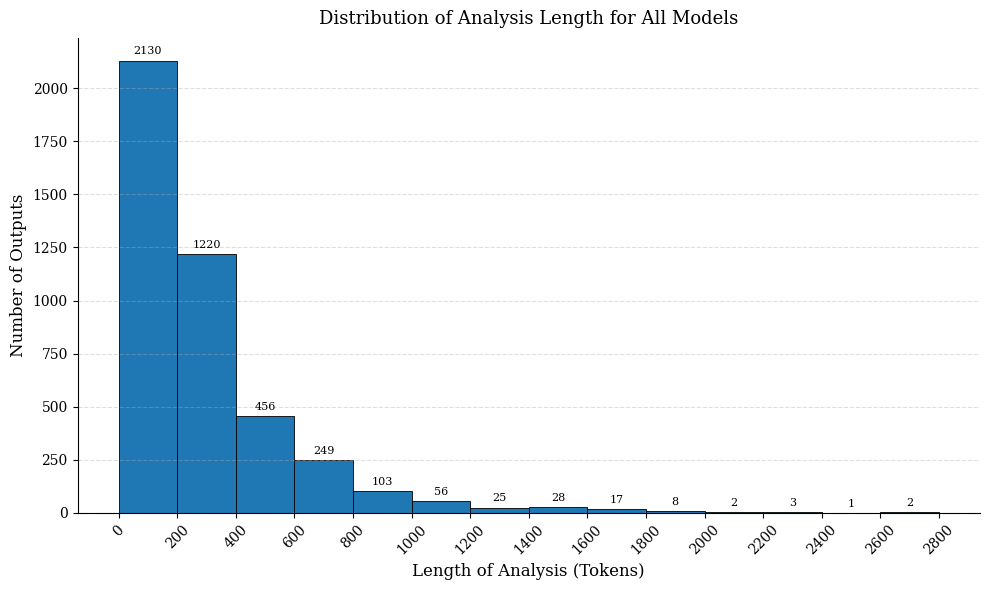

In [244]:
import json

with open("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json", 'r') as file:
    output = json.load(file)


print(get_descriptive_statistics(output))
# output
plot_token_distribution_histogram(output, "Distribution of Analysis Length for All Models", "Length of Analysis (Tokens)")



#### Reasoning Model-Tasks

       Avg Number of Tokens
count            632.000000
mean             722.393307
std              394.765943
min              230.090000
25%              462.572500
50%              614.615000
75%              805.740000
max             2776.020000


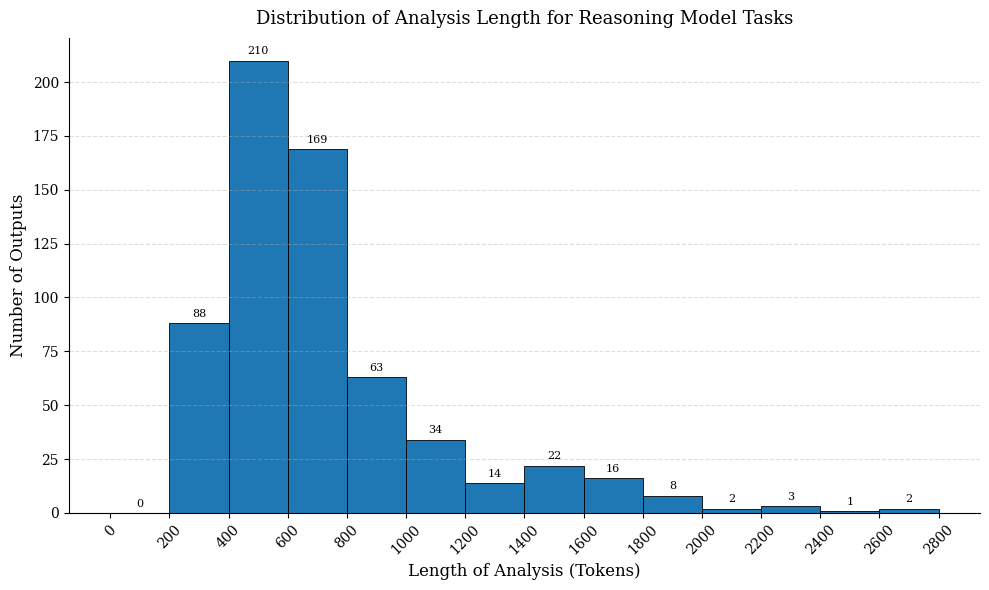

In [245]:
import json

with open("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json", 'r') as file:
    output = json.load(file)

reasoning_tasks = {}

i = 0
for k, d in output.items():
    if d["Model Name"] in reasoning_models:
        reasoning_tasks[f"{i}"] = d

        i += 1


print(get_descriptive_statistics(reasoning_tasks))
# output
plot_token_distribution_histogram(reasoning_tasks, "Distribution of Analysis Length for Reasoning Model Tasks", "Length of Analysis (Tokens)")

### Non-Reasoning Tasks

       Avg Number of Tokens
count           3340.000000
mean             225.262153
std              194.701796
min                0.000000
25%              106.295000
50%              179.390000
75%              280.237500
max             1626.940000


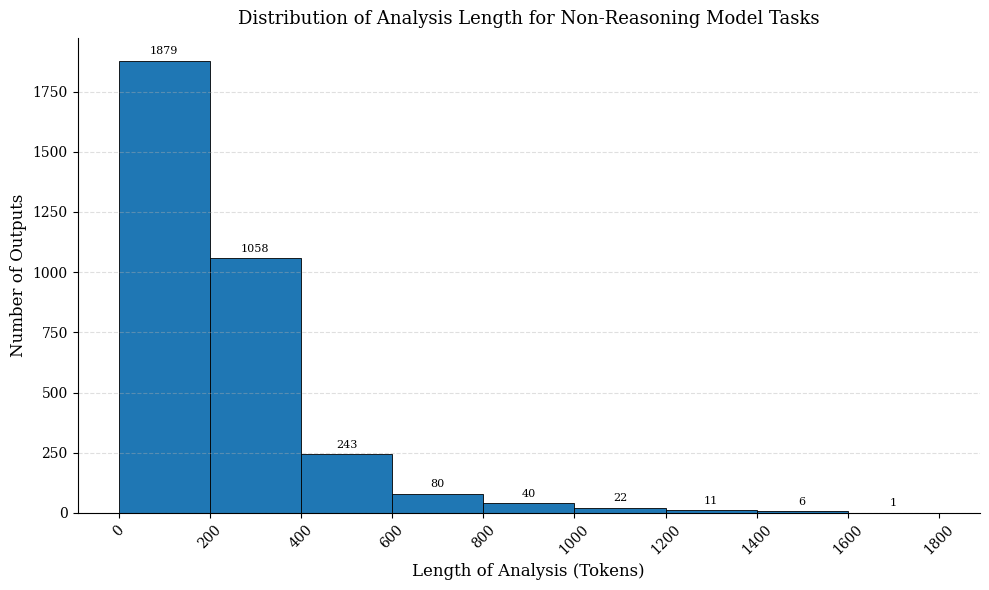

In [246]:
import json

with open("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json", 'r') as file:
    output = json.load(file)

nonreasoning_tasks = {}

i = 0
for k, d in output.items():
    if d["Model Name"] in nonreasoning_models:
        nonreasoning_tasks[f"{i}"] = d

        i += 1


print(get_descriptive_statistics(nonreasoning_tasks))
# output
plot_token_distribution_histogram(nonreasoning_tasks, "Distribution of Analysis Length for Non-Reasoning Model Tasks", "Length of Analysis (Tokens)", max_token=1700)

___

### Task Name to Simplified Name Mapping

___

In [201]:
sheet = pd.ExcelFile("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/Clinical Benchmark and LLM.xlsx")
data = sheet.parse("Task-all")

simplified_name_mapping = {} ## Maps original name --> simplified name

for row_idx, original_name in enumerate(data["Task-Original"]):
    simplified_name_mapping[original_name] = data["Task name"][row_idx]


simplified_name_mapping = {'1-1.ADE-ADE identification': 'ADE-Identification',
 '1-2.ADE-ADE relation': 'ADE-Extraction',
 '1-3.ADE-Drug dosage': 'ADE-Drug dosage',
 '3-2.BARR2-resolution': 'BARR2',
 '5.BrainMRI-AIS': 'BrainMRI-AIS',
 '6.Brateca.hospitalization': 'Brateca-Hospitalization',
 '6.Brateca.mortality': 'Brateca-Mortality',
 '7.Cantemist.CODING': 'Cantemist-Coding',
 '7.Cantemist.NER': 'Cantemis-NER',
 '7.Cantemist.Norm': 'Cantemis-Norm',
 '8.CARES.area': 'CARES-Area',
 '8.CARES.icd10_block': 'CARES ICD10 Block',
 '8.CARES.icd10_chapter': 'CARES-ICD10 Chapter',
 '8.CARES.icd10_sub_block': 'CARES-ICD10 Subblock',
 '9.CHIP-CDEE': 'CHIP-CDEE',
 '12.C-EMRS': 'C-EMRS',
 '17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM': 'CodiEsp-ICD-10-CM',
 '17-2.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-PCS': 'CodiEsp-ICD-10-PCS',
 '19.ClinicalNotes-UPMC': 'ClinicalNotes-UPMC',
 '20.clinical records from the Mexican Social Security Institute': 'PPTS',
 '21.CLINpt': 'CLINpt-NER',
 '22.CLIP': 'CLIP',
 '23.cMedQA': 'cMedQA',
 '26.DialMed': 'DialMed',
 '27.DiSMed': 'DiSMed-NER',
 '28.MIE': 'MIE',
 '29.EHRQA.primary_department': 'EHRQA-Primary department',
 '29.EHRQA.qa': 'EHRQA-QA',
 '29.EHRQA.sub_department': 'EHRQA-Sub department',
 '31.Ex4CDS': 'Ex4CDS',
 '33.GOUT-CC.consensus': 'GOUT-CC-Consensus',
 '35.n2c2 2006 - De-identification': 'n2c2 2006-De-identification',
 '37.i2b2-2009-Medication-Extraction-Challenge': 'Medication extraction',
 '38-1.i2b2-2010-Relations-Challenge-concept': 'n2c2 2010-Concept',
 '38-2.i2b2-2010-Relations-Challenge-assertion': 'n2c2 2010-Assertion',
 '38-3.i2b2-2010-Relations-Challenge-relation': 'n2c2 2010-Relation',
 '41.n2c2 2014 - De-identification': 'n2c2 2014-De-identification',
 '43.IMCS-V2-NER': 'IMCS-V2-NER',
 '46.Japanese Case Reports': 'JP-STS',
 '48.meddocan': 'meddocan',
 '51.MEDIQA_2019_Task2_RQE': 'MEDIQA 2019-RQE',
 '55.MedNLI': 'MedNLI',
 '57.MedSTS': 'MedSTS',
 '62.mtsamples': 'MTS',
 '63.MTSamples-temporal annotation': 'MTS-Temporal',
 '65.n2c2-2018-Track2-Adverse-Drug-Events-and-Medication-Extraction': 'n2c2 2018-ADE&medication',
 '66-1.NorSynthClinical-entity': 'NorSynthClinical-NER',
 '66-2.NorSynthClinical-relation': 'NorSynthClinical-RE',
 '68.NUBES': 'NUBES',
 '76-1.MTS-Dialog-MEDIQA-2023-chat-task-A': 'MEDIQA 2023-chat-A',
 '76-2.MTS-Dialog-MEDIQA-2023-sum-task-A': 'MEDIQA 2023-sum-A',
 '76-3.MTS-Dialog-MEDIQA-2023-sum-task-B': 'MEDIQA 2023-sum-B',
 '80.RuMedDaNet': 'RuMedDaNet',
 '81.CHIP-CDN': 'CBLUE-CDN',
 '82.CHIP-CTC': 'CHIP-CTC',
 '83.CHIP-MDCFNPC': 'CHIP-MDCFNPC',
 '84.MedDG': 'MedDG',
 '85.IMCS-V2-SR': 'IMCS-V2-SR',
 '86.IMCS-V2-MRG': 'IMCS-V2-MRG',
 '87.IMCS-V2-DAC': 'IMCS-V2-DAC',
 '90-1.n2c2 2014 - Heart Disease Challenge - Diabete': 'n2c2 2014-Diabetes',
 '90-2.n2c2 2014 - Heart Disease Challenge - CAD': 'n2c2 2014-CAD',
 '90-3.n2c2 2014 - Heart Disease Challenge - Hyperlipidemia': 'n2c2 2014-Hyperlipidemia',
 '90-4.n2c2 2014 - Heart Disease Challenge - Hypertension': 'n2c2 2014-Hypertension',
 '90-8.n2c2 2014 - Heart Disease Challenge - Medication': 'n2c2 2014-Medication',
 '91-1.CAS.label': 'CAS-label',
 '91-2.CAS.evidence': 'CAS-evidence',
 '93.RuMedNLI': 'RuMedNLI',
 '94.RuDReC': 'RuDReC-NER',
 '95.NorSynthClinical-PHI': 'NorSynthClinical-PHI',
 '96.RuCCoN.NER': 'RuCCoN',
 '97.CLISTER': 'CLISTER',
 '98.BRONCO150.NER_status': 'BRONCO150-NER&Status',
 '99.CARDIO:DE': 'CARDIO-DE',
 '100.GraSSCo_PHI': 'GraSSCo PHI',
 '101.IFMIR.IncidentType': 'IFMIR-Incident type',
 '101.IFMIR.NER': 'IFMIR-NER',
 '101.IFMIR.NER_factuality': 'IFMIR - NER&factuality',
 '102.iCorpus': 'iCorpus',
 '103.icliniq-10k': 'icliniq-10k',
 '104.HealthCareMagic-100k': 'HealthCareMagic-100k',
 '105.MIMIC-IV CDM': 'MIMIC-IV CDM',
 '106.MIMIC-III Outcome.LoS': 'MIMIC-III Outcome.LoS',
 '106.MIMIC-III Outcome.Mortality': 'MIMIC-III Outcome.Mortality',
 '107.MIMIC-IV BHC': 'MIMIC-IV BHC',
 '108.MIMIC-IV DiReCT.Dis': 'MIMIC-IV DiReCT.Dis',
 '108.MIMIC-IV DiReCT.PDD': 'MIMIC-IV DiReCT.PDD'}

___

## Plot Token Range vs. Performance Drop


In [202]:
google_sheet = pd.ExcelFile("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/CoT-Difference-Sheet.xlsx")
data = google_sheet.parse("All-Sheet")

nonreasoning_models = set()
all_models = set()

# Create a new dictionary mapping "{Task Name}, {Model Name}": Relative difference
performance_map = {}

for row_idx, task_name in enumerate(data["Task Name"]):
    model_name = data["Model Name"][row_idx]
    all_models.add(model_name)

    if model_name not in reasoning_models:
        nonreasoning_models.add(model_name)

    new_name = f"{task_name}, {model_name}"

    relative_diff = data["Relative Difference"][row_idx]

    performance_map[new_name] = relative_diff

forbidden = {
    '33.GOUT-CC.predict',
    "96.RuCCoN.NER_Nor",
    "98.BRONCO150.NER_Nor",
    '90-5.n2c2 2014 - Heart Disease Challenge - Obesity',
    '90-7.n2c2 2014 - Heart Disease Challenge - Smoker',
    '90-6.n2c2 2014 - Heart Disease Challenge - Family History',
}

## Plotting Function

In [230]:
import json
import matplotlib.pyplot as plt

def plot_avg_performance_by_token_range(
    json_path,
    performance_map,
    simplified_name_mapping,
    forbidden,
    bin_size=200,
    max_token=2800,
    valid_models = [],
    title = '',
    x_axis = ''
):
    # 1. Load your results
    with open(json_path, 'r') as f:
        results_data = json.load(f)

    # 2. Prepare your bins
    edges = list(range(0, max_token + bin_size, bin_size))

    # 3. Initialize buckets
    buckets = {
        f"token_{edges[i]}_{edges[i+1]}": []
        for i in range(len(edges) - 1)
    }

    # 4. Fill the buckets with relative performance values
    for d in results_data.values():
        task_name  = d["Task Name"]
        if task_name in forbidden:
            continue
        task_name  = simplified_name_mapping[task_name]
        model_name = d["Model Name"]

        # Normalize model names
        model_name = {
            "gpt-35-turbo": "gpt-35-turbo-0125",
            "gpt-4o": "gpt-4o-0806",
            "gemini-1.5-pro": "gemini-1.5-pro-002",
            "gemini-2.0-flash": "gemini-2.0-flash-001"
        }.get(model_name, model_name)

        if model_name not in valid_models:
            continue

        num_tokens = d["Avg Number of Tokens"]
        perf = performance_map[f"{task_name}, {model_name}"]

        # Assign to bucket
        idx = min(int(num_tokens // bin_size), len(edges) - 2)
        bucket_name = f"token_{edges[idx]}_{edges[idx+1]}"
        buckets[bucket_name].append(perf)

    # 5. Compute average relative difference
    avg_rel_diff = {
        bucket: (round(sum(values) / len(values), 2) if values else None)
        for bucket, values in buckets.items()
    }

    # Flip signs to represent performance drop
    avg_drop = {k: -v for k, v in avg_rel_diff.items() if v is not None}

    # Define bins
    bins = list(range(0, max_token + 1, bin_size))

    # Apply publication‐ready styling
    plt.rcParams.update({
        "font.family": "serif",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
    })

    # Prepare x and y
    x = bins[:-1]
    y = [avg_drop.get(f"token_{bins[i]}_{bins[i+1]}", 0) for i in range(len(x))]

    blue = '#1f77b4'
    red  = '#d62728'
    colors = [blue if val >= 0 else red for val in y]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(
        x,
        y,
        width=bin_size,
        align='edge',
        edgecolor='black',
        color=colors,
        linewidth=0.6
    )

    ax.bar_label(bars, padding=3, fontsize=8, fmt="%.2f%%")
    ax.set_xlabel(x_axis)
    ax.set_ylabel("Average Change in Performance (%)")
    ax.set_title(title, fontsize=13, pad=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_xticks(bins)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()



### Usage: All Models

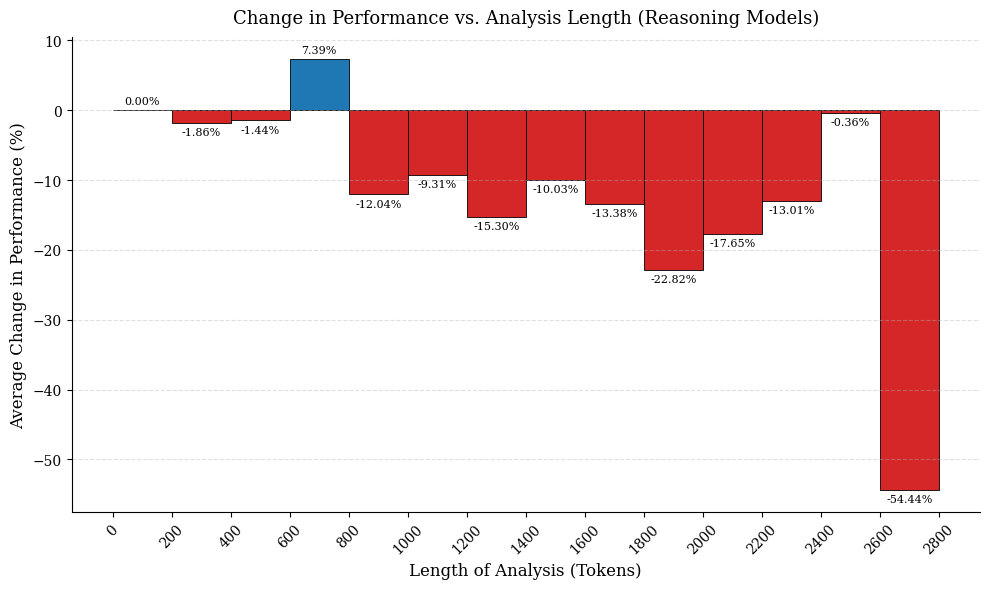

In [247]:
plot_avg_performance_by_token_range(
    json_path="/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json",
    performance_map=performance_map,
    simplified_name_mapping=simplified_name_mapping,
    forbidden=forbidden,
    valid_models=reasoning_models,
    title = "Change in Performance vs. Analysis Length (Reasoning Models)",
    x_axis="Length of Analysis (Tokens)"   
)


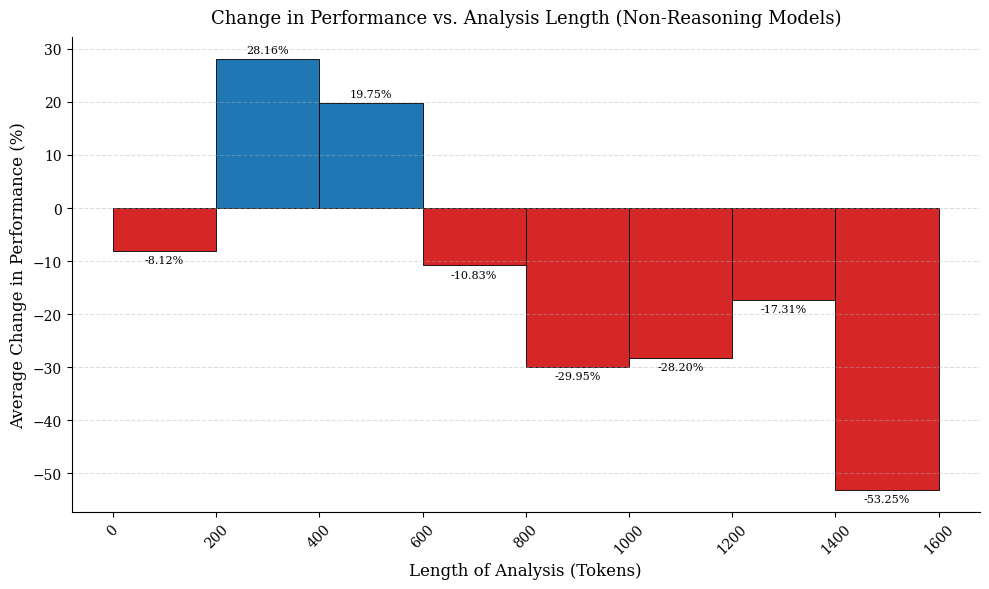

In [251]:
plot_avg_performance_by_token_range(
    json_path="/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json",
    performance_map=performance_map,
    simplified_name_mapping=simplified_name_mapping,
    forbidden=forbidden,
    valid_models=nonreasoning_models,
    title = "Change in Performance vs. Analysis Length (Non-Reasoning Models)",
    x_axis="Length of Analysis (Tokens)",
    max_token=1700
)

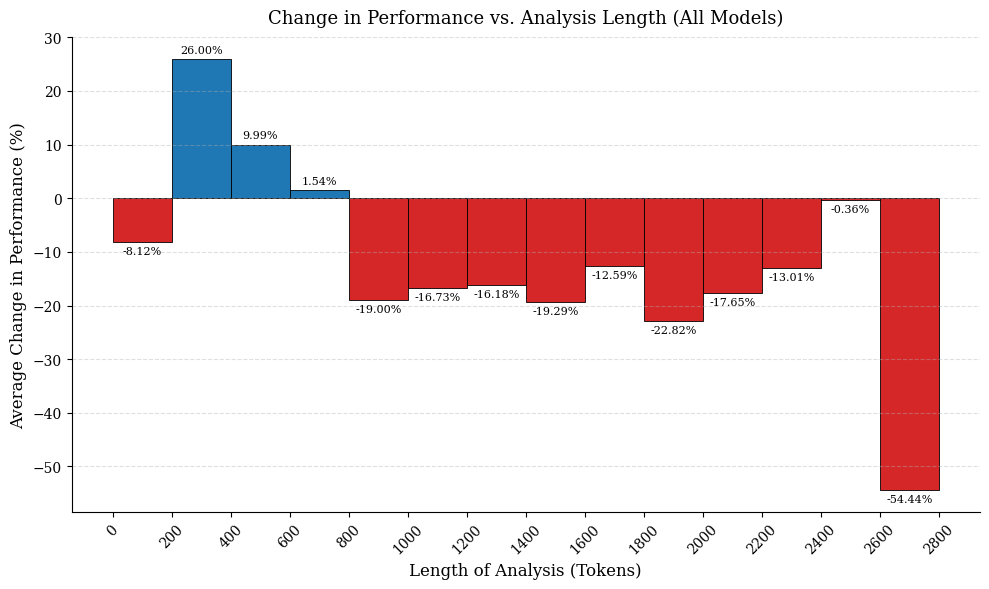

In [249]:
plot_avg_performance_by_token_range(
    json_path="/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/dict_revised_results_combined.json",
    performance_map=performance_map,
    simplified_name_mapping=simplified_name_mapping,
    forbidden=forbidden,
    valid_models=all_models,
    title = "Change in Performance vs. Analysis Length (All Models)",
    x_axis="Length of Analysis (Tokens)"
)